VGGT
====

**VGGT: Visual Geometry Grounded Transformer**

 * Paper: https://arxiv.org/abs/2503.11651

![VGG Overview](../assets/vggt_overview.png)

![VGGT Model](../assets/vggt_model_overview.png)

```bash
git clone https://github.com/facebookresearch/vggt.git

pip install torch torchvision
pip install transformers
pip install einops
```

In [1]:
import sys
import matplotlib.pyplot as plt
import torch
sys.path.append("vggt")  # remember to clone the repo
from vggt.models.vggt import VGGT
from vggt.utils.load_fn import load_and_preprocess_images

device = "cuda" if torch.cuda.is_available() else "cpu"
# bfloat16 is supported on Ampere GPUs (Compute Capability 8.0+) 
dtype = (
    torch.bfloat16
    if torch.cuda.get_device_capability()[0] >= 8
    else torch.float16
)
print(f"Using device: {device}, dtype: {dtype}")

model = VGGT.from_pretrained("facebook/VGGT-1B")
model.eval().to(device);

/home/pyml/anaconda3/envs/py311/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Using device: cuda, dtype: torch.bfloat16


Images shape: torch.Size([1, 3, 518, 518])


/home/pyml/git_vmirly/GenAI-Hub/VGGT/vggt/vggt/models/vggt.py:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


Predictions: dict_keys(['pose_enc', 'depth', 'depth_conf', 'world_points', 'world_points_conf', 'images'])
pose_enc: torch.Size([1, 1, 9])
depth: torch.Size([1, 1, 518, 518, 1])
depth_conf: torch.Size([1, 1, 518, 518])
world_points: torch.Size([1, 1, 518, 518, 3])
world_points_conf: torch.Size([1, 1, 518, 518])
images: torch.Size([1, 1, 3, 518, 518])


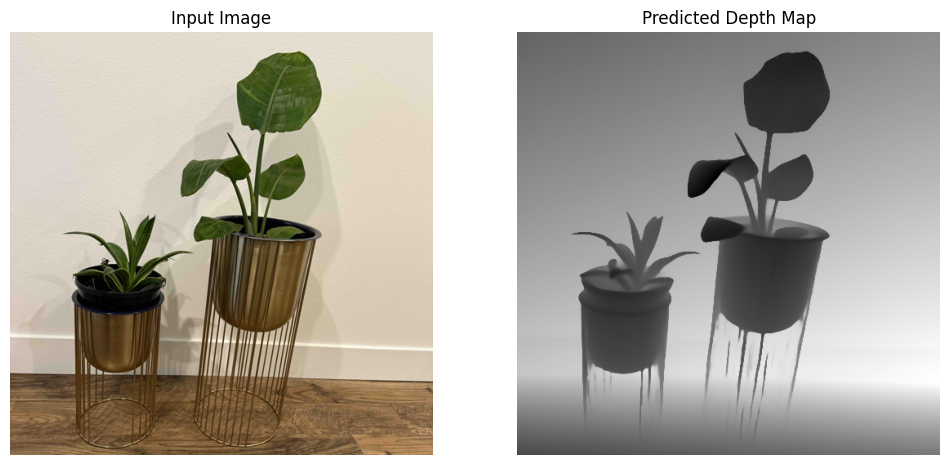

In [2]:
# inference with a single image
image_paths = ["../samples/plants.jpg"]
images = load_and_preprocess_images(image_paths).to(device)
print(f"Images shape: {images.shape}")

with torch.no_grad():
    with torch.amp.autocast("cuda", dtype=dtype):
        # Predict attributes including cameras,
        # depth maps, and point maps.
        predictions = model(images)

print(f"Predictions: {predictions.keys()}")
for key in predictions:
    print(f"{key}: {predictions[key].shape}")

# Visualize the depth map
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(images[0].permute(1, 2, 0).cpu())
ax[0].set_title("Input Image")
ax[0].axis("off")
depth_map = predictions["depth"][0, 0, :, :, 0].cpu()
ax[1].imshow(depth_map, cmap="gray")
ax[1].set_title("Predicted Depth Map")
ax[1].axis("off")
plt.show()

In [ ]:
from demo_viser import viser_wrapper
from vggt.utils.pose_enc import pose_encoding_to_extri_intri

use_point_map = False  # use depth map for 3D reconstruction
background_mode = True
port_number = "8082"
conf_threshold = 25.0
mask_sky = False
image_folder = "output/"

image_paths = [
    f"../samples/multiview/plant_view{i}.jpg" for i in range(1, 6)
]
images = load_and_preprocess_images(image_paths).to(device)

with torch.no_grad():
    with torch.amp.autocast("cuda", dtype=dtype):
        predictions = model(images)

print("Converting pose encoding to extrinsic and intrinsic matrices...")
extrinsic, intrinsic = pose_encoding_to_extri_intri(predictions["pose_enc"], images.shape[-2:])
predictions["extrinsic"] = extrinsic
predictions["intrinsic"] = intrinsic

print("Processing model outputs...")
for key in predictions.keys():
    if isinstance(predictions[key], torch.Tensor):
        predictions[key] = predictions[key].cpu().numpy().squeeze(0)  # remove batch dimension and convert to numpy


print("Starting viser visualization...")

viser_wrapper(
    predictions,
    port=port_number,
    init_conf_threshold=conf_threshold,
    use_point_map=use_point_map,
    background_mode=background_mode,
    mask_sky=mask_sky,
    image_folder=image_folder,
)
print("Visualization complete")

Converting pose encoding to extrinsic and intrinsic matrices...
Processing model outputs...
Starting viser visualization...
Starting viser server on port 8082


/home/pyml/git_vmirly/GenAI-Hub/VGGT/vggt/vggt/models/vggt.py:67: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):


╭──────────────── viser ────────────────╮
│             ╷                         │
│   HTTP      │ http://localhost:8082   │
│   Websocket │ ws://localhost:8082     │
│             ╵                         │
╰───────────────────────────────────────╯

100%|██████████| 5/5 [00:00<00:00, 302.55it/s]

Starting viser server...
Visualization complete


(viser) Connection opened (0, 1 total), 45 persistent messages

(viser) Connection closed (0, 0 total)

(viser) Connection opened (1, 1 total), 45 persistent messages

(viser) Connection closed (1, 0 total)

![3D Visualization with Viser](visualization_3d_viser.png)